In [ ]:
import pandas as pd
import numpy as np 
import itertools
import tensorflow
from tensorflow import keras
from sklearn import metrics
from sklearn.metrics import confusion_matrix
from tensorflow.keras.preprocessing.image import ImageDataGenerator, img_to_array, load_img 
from tensorflow.keras.models import Sequential
from tensorflow.keras import optimizers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.layers import Dropout, Flatten, Dense,BatchNormalization,Conv2D,MaxPool2D
from tensorflow.keras import applications 
from keras.utils.np_utils import to_categorical 
import matplotlib.pyplot as plt 
import matplotlib.image as mpimg
%matplotlib inline
import math 
import datetime
import time
import sys
if not sys.warnoptions:
    import warnings
    warnings.simplefilter("ignore")

In [14]:
img_width,img_height = 128,128
train_data_dir=r'C:\Users\Welcome\Desktop\xray_dataset_covid19\train'
test_data_dir=r'C:\Users\Welcome\Desktop\xray_dataset_covid19\test'
epochs=7
batch_size=32

# Image Augementation

In [15]:
def get_generator(path):
    generator = datagen.flow_from_directory( 
        path, 
        target_size=(img_width, img_height), 
        batch_size=batch_size, 
        class_mode="categorical", 
        shuffle=False) 

    nb_samples = len(generator.filenames) 
    num_classes = len(generator.class_indices) 

    predict_size_train = int(math.ceil(nb_samples / batch_size)) 
    # get the class labels for the training data, in the original order 
    labels = generator.classes 
    # convert the training labels to categorical vectors 
    labels = to_categorical(labels, num_classes=num_classes)
    return (generator,nb_samples,predict_size_train,labels)

In [16]:
datagen = ImageDataGenerator(rescale=1. / 255)

In [17]:
generator_train,nb_train_samples,predict_size_train,train_labels = get_generator(train_data_dir)
generator_test,nb_test_samples,predict_size_test,test_labels    = get_generator(test_data_dir)
num_classes = 3
class_labels=list(generator_train.class_indices.keys())
print(class_labels)
print(generator_test.class_indices)

Found 222 images belonging to 3 classes.
Found 60 images belonging to 3 classes.
['COVID', 'NORMAL', 'PNEUMONIA']
{'COVID': 0, 'NORMAL': 1, 'PNEUMONIA': 2}


# Apply Pretrained model

In [19]:
def apply_pretrainedModel(pretrained_model,generator,predict_size):
    return pretrained_model.predict_generator(generator, predict_size)

# Apply Transfer Learning

In [21]:
def cnn_after_pretrainedModel(input_shape):
    model = Sequential() 
    model.add(Flatten(input_shape=input_shape)) 
    model.add(Dense(128, activation=keras.layers.LeakyReLU(alpha=0.3))) 
    model.add(Dropout(0.5)) 
    model.add(Dense(64, activation=keras.layers.LeakyReLU(alpha=0.3))) 
    model.add(Dropout(0.3)) 
    model.add(Dense(num_classes, activation='softmax'))
    model.compile(loss='categorical_crossentropy',
       optimizer=optimizers.Adam(lr=1e-4),
       metrics=['acc'])
    return model;

In [22]:
def transfer_learning(pretrained_model,epochs=25):
    #Appling Pretrained Model to train and test datasets
    train_data = apply_pretrainedModel(pretrained_model,generator_train,predict_size_train)
    test_data  = apply_pretrainedModel(pretrained_model,generator_test,predict_size_test)
    print("train data is shape : ",train_data.shape)
    model      = cnn_after_pretrainedModel(train_data.shape[1:])
    history = model.fit(train_data, train_labels, 
       epochs=epochs,
       batch_size=batch_size, 
       validation_data=(test_data, test_labels))
    (eval_loss, eval_accuracy) = model.evaluate( 
        test_data, test_labels, batch_size=batch_size,     verbose=1)
    print("[INFO] accuracy: {:.2f}%".format(eval_accuracy * 100)) 
    print("[INFO] Loss: {}".format(eval_loss))
    
    return train_data,test_data,model,history,eval_accuracy

In [23]:
def plot_graphs(history):
    #Graphing our training and validation
    acc = history.history['acc']
    val_acc = history.history['val_acc']
    loss = history.history['loss']
    val_loss = history.history['val_loss']
    epochs = range(len(acc))
    plt.plot(epochs, acc, 'r', label='Training acc')
    plt.plot(epochs, val_acc, 'b', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.ylabel('accuracy') 
    plt.xlabel('epoch')
    plt.legend()
    plt.figure()
    plt.plot(epochs, loss, 'r', label='Training loss')
    plt.plot(epochs, val_loss, 'b', label='Validation loss')
    plt.title('Training and validation loss')
    plt.ylabel('loss') 
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

# Build Model VGG

In [26]:
model_name="VGG"
pretrained_model_vgg  = applications.VGG19(include_top=False, weights='imagenet')
train_data,test_data,model_vgg,history_vgg,acc_vgg = transfer_learning(pretrained_model_vgg)
print()

train data is shape :  (222, 4, 4, 512)
Epoch 1/25
7/7 [==============================] - 1s 53ms/step - loss: 1.2295 - acc: 0.4414 - val_loss: 0.9684 - val_acc: 0.4833
Epoch 2/25
7/7 [==============================] - 0s 20ms/step - loss: 1.0593 - acc: 0.4955 - val_loss: 0.7604 - val_acc: 0.8333
Epoch 3/25
7/7 [==============================] - 0s 17ms/step - loss: 0.7534 - acc: 0.6712 - val_loss: 0.6239 - val_acc: 0.8667
Epoch 4/25
7/7 [==============================] - 0s 19ms/step - loss: 0.7042 - acc: 0.7432 - val_loss: 0.5739 - val_acc: 0.8000
Epoch 5/25
7/7 [==============================] - 0s 19ms/step - loss: 0.5474 - acc: 0.8153 - val_loss: 0.4794 - val_acc: 0.9167
Epoch 6/25
7/7 [==============================] - 0s 19ms/step - loss: 0.5305 - acc: 0.8198 - val_loss: 0.4054 - val_acc: 0.9167
Epoch 7/25
7/7 [==============================] - 0s 18ms/step - loss: 0.4477 - acc: 0.8514 - val_loss: 0.3788 - val_acc: 0.8833
Epoch 8/25
7/7 [==============================] - 0s 19ms

# Visulize VGG Training and Testing

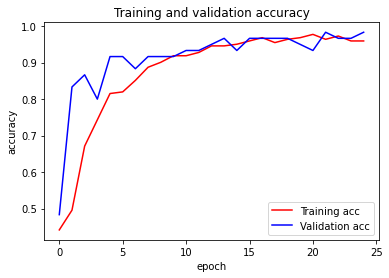

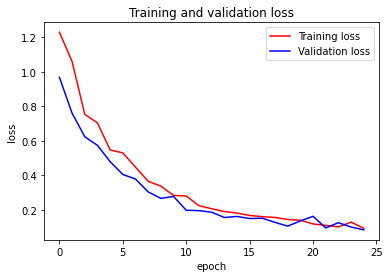

In [28]:
plot_graphs(history_vgg)
preds=np.round(model_vgg.predict(test_data),0)

# Performance Metrics 

In [29]:
classify_matrics_vgg=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_vgg)

              precision    recall  f1-score   support

       COVID       1.00      1.00      1.00        20
      NORMAL       1.00      0.95      0.97        20
   PNEUMONIA       0.95      1.00      0.98        20

   micro avg       0.98      0.98      0.98        60
   macro avg       0.98      0.98      0.98        60
weighted avg       0.98      0.98      0.98        60
 samples avg       0.98      0.98      0.98        60



# Applying GOOGLE NET

In [30]:
#Loading Pre-trained Model
model_name="INCEPTION NET"
pretrained_model_googleNet  = applications.InceptionV3(include_top=False, weights='imagenet')
train_data,test_data,model_googleNet,history_googleNet,acc_googleNet = transfer_learning(pretrained_model_googleNet)

train data is shape :  (222, 2, 2, 2048)
Epoch 1/25
7/7 [==============================] - 1s 44ms/step - loss: 2.4171 - acc: 0.4414 - val_loss: 0.4073 - val_acc: 0.8000
Epoch 2/25
7/7 [==============================] - 0s 18ms/step - loss: 1.0003 - acc: 0.7072 - val_loss: 0.5523 - val_acc: 0.7833
Epoch 3/25
7/7 [==============================] - 0s 18ms/step - loss: 0.7165 - acc: 0.7162 - val_loss: 0.3742 - val_acc: 0.8833
Epoch 4/25
7/7 [==============================] - 0s 19ms/step - loss: 0.4991 - acc: 0.8333 - val_loss: 0.3685 - val_acc: 0.8667
Epoch 5/25
7/7 [==============================] - 0s 17ms/step - loss: 0.4136 - acc: 0.8604 - val_loss: 0.3926 - val_acc: 0.8167
Epoch 6/25
7/7 [==============================] - 0s 19ms/step - loss: 0.3211 - acc: 0.8739 - val_loss: 0.4274 - val_acc: 0.8167
Epoch 7/25
7/7 [==============================] - 0s 17ms/step - loss: 0.2886 - acc: 0.9009 - val_loss: 0.3961 - val_acc: 0.8667
Epoch 8/25
7/7 [==============================] - 0s 18m

# Visualize GOOGLE NET Training and Testing

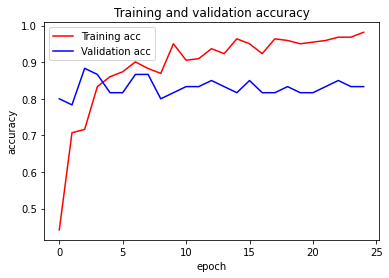

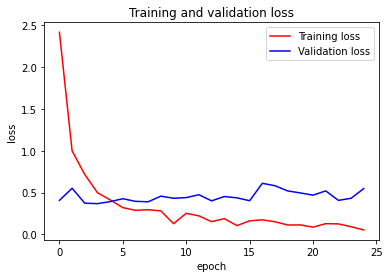

In [31]:
plot_graphs(history_googleNet)
preds=np.round(model_googleNet.predict(test_data),0)

# Performance metrics of GOOGLE NET

In [32]:
classify_matrics_googleNet=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_googleNet)

              precision    recall  f1-score   support

       COVID       0.95      0.90      0.92        20
      NORMAL       0.81      0.65      0.72        20
   PNEUMONIA       0.76      0.95      0.84        20

   micro avg       0.83      0.83      0.83        60
   macro avg       0.84      0.83      0.83        60
weighted avg       0.84      0.83      0.83        60
 samples avg       0.83      0.83      0.83        60



# Applying ResNet50

In [33]:
#Loading Pre-trained Model
model_name="INCEPTION NET"
pretrained_model_resNet  = applications.ResNet50(include_top=False, weights='imagenet')
train_data,test_data,model_resNet,history_resNet,acc_resNet= transfer_learning(pretrained_model_resNet)

train data is shape :  (222, 4, 4, 2048)
Epoch 1/25
7/7 [==============================] - 1s 82ms/step - loss: 1.3204 - acc: 0.3333 - val_loss: 1.1677 - val_acc: 0.3333
Epoch 2/25
7/7 [==============================] - 0s 54ms/step - loss: 1.2323 - acc: 0.3784 - val_loss: 1.0764 - val_acc: 0.3333
Epoch 3/25
7/7 [==============================] - 0s 56ms/step - loss: 1.1348 - acc: 0.3829 - val_loss: 1.0780 - val_acc: 0.3667
Epoch 4/25
7/7 [==============================] - 0s 53ms/step - loss: 1.1097 - acc: 0.3784 - val_loss: 1.0546 - val_acc: 0.7000
Epoch 5/25
7/7 [==============================] - 0s 59ms/step - loss: 1.0754 - acc: 0.3964 - val_loss: 1.0527 - val_acc: 0.5333
Epoch 6/25
7/7 [==============================] - 0s 58ms/step - loss: 1.0896 - acc: 0.4189 - val_loss: 1.0374 - val_acc: 0.7333
Epoch 7/25
7/7 [==============================] - 0s 56ms/step - loss: 1.0632 - acc: 0.4595 - val_loss: 1.0303 - val_acc: 0.7000
Epoch 8/25
7/7 [==============================] - 0s 56m

# Visualize ResNet Training and Testing

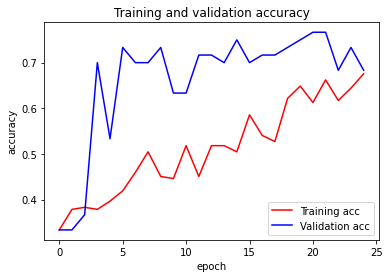

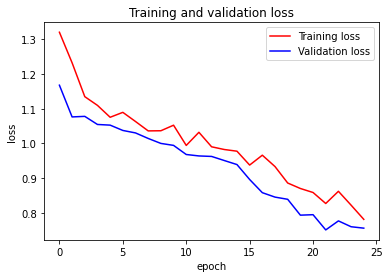

In [34]:
plot_graphs(history_resNet)
preds=np.round(model_resNet.predict(test_data),0)

# Performance metrics of ResNet

In [35]:
classify_matrics_resNet=metrics.classification_report(test_labels,preds,target_names=class_labels)
print(classify_matrics_resNet)

              precision    recall  f1-score   support

       COVID       0.95      1.00      0.98        20
      NORMAL       0.59      0.65      0.62        20
   PNEUMONIA       0.00      0.00      0.00        20

   micro avg       0.77      0.55      0.64        60
   macro avg       0.51      0.55      0.53        60
weighted avg       0.51      0.55      0.53        60
 samples avg       0.55      0.55      0.55        60



# Comparing above three models(VGG19,InceptionV3,ResNet50)

In [37]:
print("Accuracies of Models")
print("VGG\t\t",acc_vgg)
print("Google Net\t",acc_googleNet)
print("ResNet\t\t",acc_resNet)

Accuracies of Models
VGG		 0.9833333492279053
Google Net	 0.8333333134651184
ResNet		 0.6833333373069763


# Testing a single image

In [38]:
def read_image(file_path):
    print("[INFO] loading and preprocessing image…") 
    image = load_img(file_path, target_size=(img_width, img_height))
    image = img_to_array(image) 
    image = np.expand_dims(image, axis=0)
    image /= 255.
    return image

In [39]:
#from tensorflow.keras.models import load_model
#new_model=load_model("C:/Users/Welcome/Desktop/commomModel.h5")

[INFO] loading and preprocessing image…
preds [0.9781416  0.01048844 0.01136986]
ID: 0, Label: COVID 97.81%
ID: 1, Label: NORMAL 1.05%
ID: 2, Label: PNEUMONIA 1.14%
Final Decision:
.
..
...
ID: 0, Label: COVID


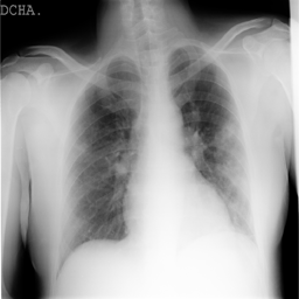

In [41]:
def test_single_image(pretrained_model,model,path):
    images = read_image(path)
    time.sleep(.5)
    bt_prediction = pretrained_model.predict(images) 
    preds = model.predict_proba(bt_prediction)
    print("preds",preds[0])
    for idx, animal, x in zip(range(0,3), class_labels , preds[0]):
        print("ID: {}, Label: {} {}%".format(idx, animal, round(x*100,2) ))
    print('Final Decision:')
    time.sleep(.5)
    for x in range(3):
        print('.'*(x+1))
    time.sleep(.2)
    class_predicted = model.predict_classes(bt_prediction)
    class_dictionary = generator_test.class_indices 
    inv_map = {v: k for k, v in class_dictionary.items()} 
    print("ID: {}, Label: {}".format(class_predicted[0],  inv_map[class_predicted[0]])) 
    return load_img(path)
path = r'G:\MAIN PROJECT DATA SET\train\COVID\COVID-100.png'
test_single_image(pretrained_model_vgg,model_vgg,path)